In [189]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import compose
from sklearn import impute
from sklearn import model_selection
from sklearn import feature_selection
from sklearn import tree
from sklearn import pipeline
from sklearn import ensemble

from scipy import stats

In [190]:
import graphviz

In [191]:
df = pd.read_csv("data/final_train.csv", index_col=0)
df.head()

,Activity,"angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyAccMean,gravity)","angle(tBodyGyroJerkMean,gravityMean)","angle(tBodyGyroMean,gravityMean)",energy-mean(),"fBodyAcc-bandsEnergy()-1,16",...,tGravityAccMag-energy(),tGravityAccMag-entropy(),tGravityAccMag-iqr(),tGravityAccMag-mad(),tGravityAccMag-max(),tGravityAccMag-mean(),tGravityAccMag-min(),tGravityAccMag-sma(),tGravityAccMag-std(),void()
0,STANDING,-1.574191,-0.805700,-2.453831,-1.861714,0.115517,-2.023369,3.125860,-9.474436,3.622600,...,5.049130,3.272281,5.103018,-0.823302,3.063681,-0.928676,-1.007695,3.094236,1.669987,1.0
1,WALKING_UPSTAIRS,-1.568669,-0.612620,-2.488338,-1.751117,0.218134,0.280294,7.953403,-0.679894,2.512880,...,4.565443,4.440779,3.288399,-2.689605,1.705341,-0.822617,-0.572410,-2.187890,-0.544652,2.0
2,LAYING,-1.548333,-0.139628,-2.380889,-1.915239,0.067613,-0.887342,6.007361,-11.906904,3.621984,...,5.059609,2.296603,5.344174,-0.549843,3.272225,-0.940610,-1.031522,-2.071755,2.024442,3.0
3,WALKING,-1.574094,-0.793443,-2.449959,-1.842741,-0.195625,-0.950671,2.104353,-11.906121,3.355701,...,4.860758,4.177535,3.950012,-0.322642,2.366287,-0.866937,-0.696431,1.863375,0.550414,2.0
4,LAYING,-1.548333,-0.139628,-2.380889,NaN,0.067613,-0.887342,6.007361,-11.970485,3.621984,...,5.059609,2.296603,5.344174,-0.549843,3.272225,-0.940610,-1.031522,-2.102513,2.024442,3.0


In [192]:
y = df["Activity"]
X = df.drop(columns=["Activity", "subject", "void()"])

In [193]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [140]:
p = pipeline.Pipeline(
    [
        ("imputer", impute.SimpleImputer()),
        ("feature_selection", feature_selection.SelectFromModel(ensemble.RandomForestClassifier(random_state=42))),
        ("tree", tree.DecisionTreeClassifier(random_state=42))
    ]
)

In [194]:
imputer = impute.SimpleImputer()
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [144]:
selector = feature_selection.SelectFromModel(ensemble.RandomForestClassifier(random_state=42))
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

In [195]:
tree_clf = tree.DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [196]:
path = tree_clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

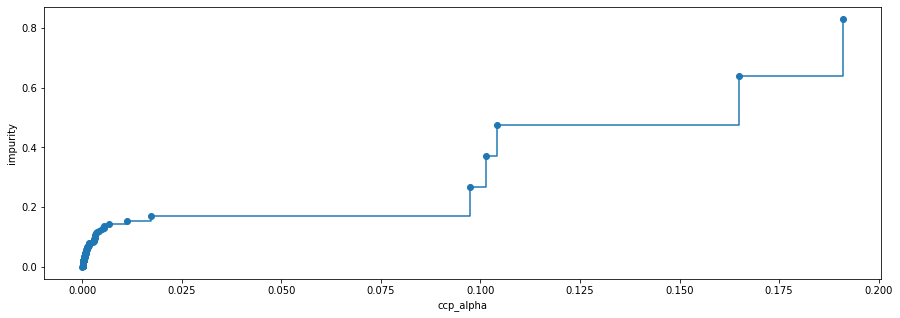

In [197]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(ccp_alphas, impurities, marker='o', drawstyle="steps-post")
ax.set_xlabel("ccp_alpha")
ax.set_ylabel("impurity")
plt.show()

In [199]:
from tqdm import tqdm

In [200]:
clfs = [
    tree.DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha, ).fit(X_train, y_train)
    for ccp_alpha in tqdm(ccp_alphas)
]

100%|██████████| 149/149 [09:20<00:00,  3.76s/it]


In [201]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

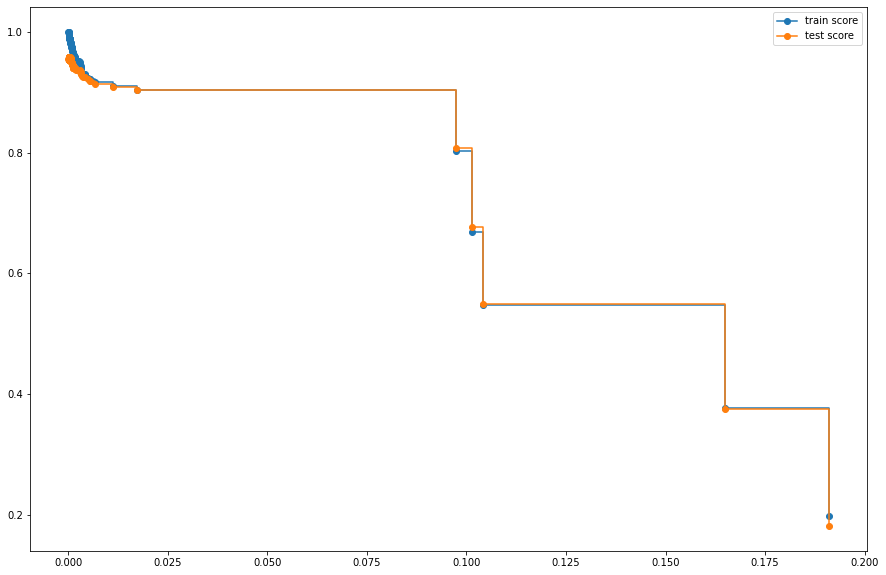

In [212]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(ccp_alphas, train_scores, marker='o', drawstyle="steps-post", label="train score")
ax.plot(ccp_alphas, test_scores, marker='o', drawstyle="steps-post", label="test score")
ax.legend()

plt.show()

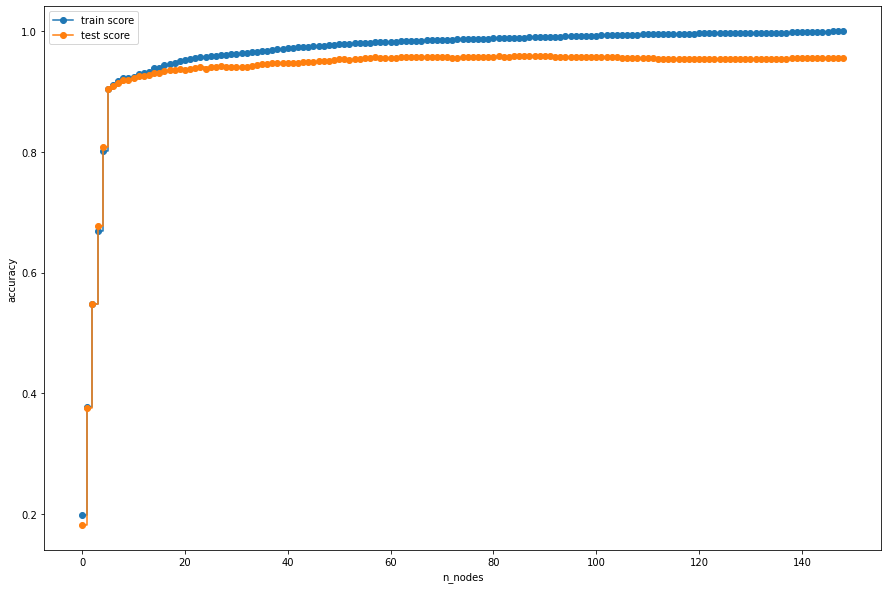

In [213]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(range(len(train_scores)), train_scores[::-1], marker='o', drawstyle="steps-post", label="train score")
ax.plot(range(len(test_scores)), test_scores[::-1], marker='o', drawstyle="steps-post", label="test score")

ax.set_ylabel("accuracy")
ax.set_xlabel("n_nodes")
ax.legend()

plt.show()

In [226]:
alpha = ccp_alphas[-10]
alpha

0.005415969580145157

In [227]:
final_tree_clf = tree.DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
final_tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.005415969580145157, random_state=42)

In [228]:
final_tree_clf.score(X_test, y_test)

0.9192966636609559

In [229]:
dot_data = tree.export_graphviz(
    final_tree_clf,
    feature_names=X.columns,
    class_names=final_tree_clf.classes_
)
graph = graphviz.Source(dot_data)
graph.render("result")

'result.pdf'

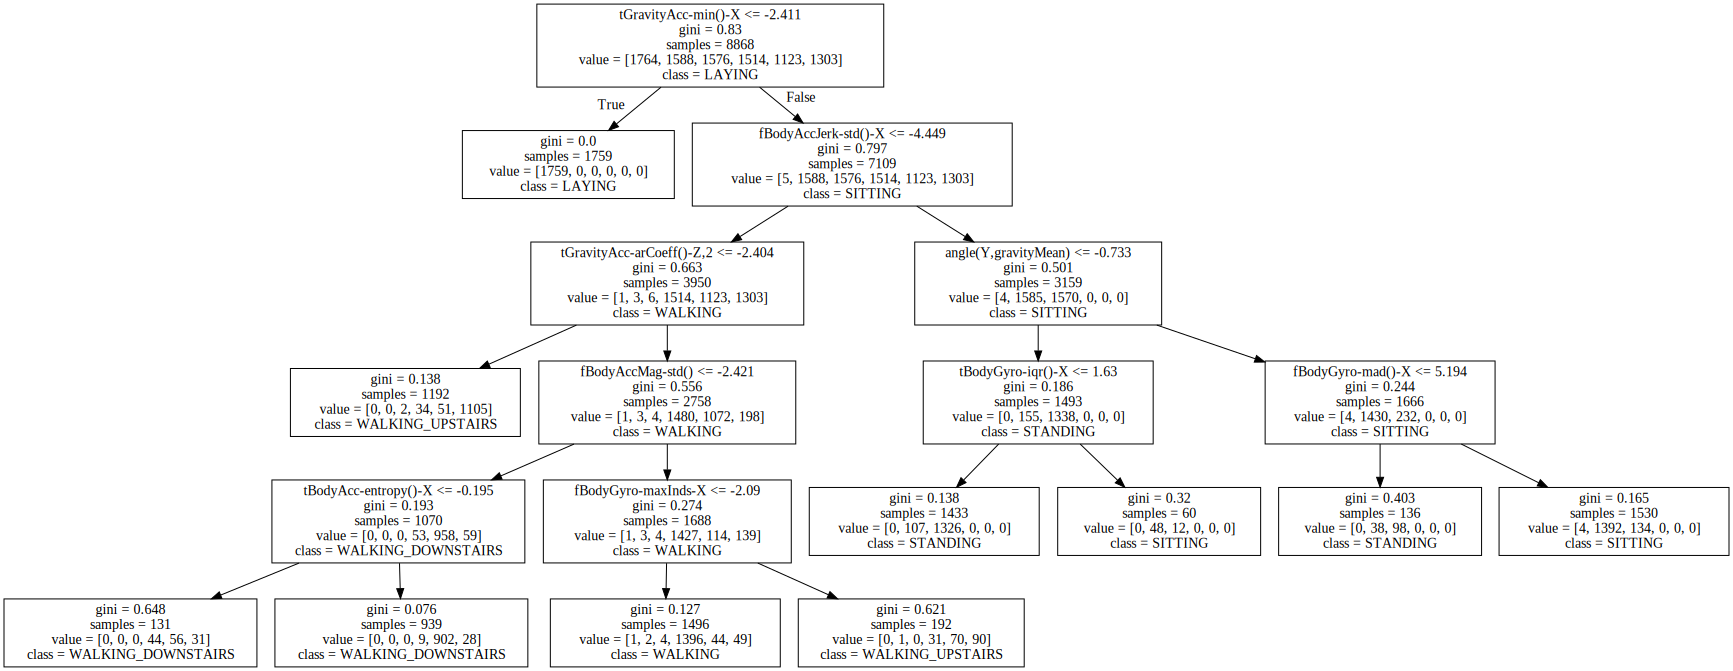

In [230]:
graph

In [232]:
p = pipeline.Pipeline(
    [
        ("imputer", imputer),
        ("tree", final_tree_clf)
    ]
)

In [233]:
import joblib

In [235]:
joblib.dump(p, "pipeline.joblib")

['pipeline.joblib']

<AxesSubplot:title={'center':'tGravityAcc-min()-X'}, xlabel='Activity'>

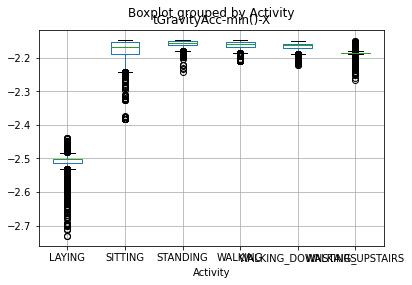

In [241]:
plt.boxplot(df[]"tGravityAcc-min()-X", "Activity")